In [1]:
import numpy as np
import pandas as pd
from PIL import Image
from wordcloud import WordCloud
import arabic_reshaper 
from bidi.algorithm import get_display
from nltk.corpus import stopwords
import re
import datetime
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline




In [2]:
def plot_time(tweets):
    time=tweets.groupby('hour posted').count().reset_index()[['hour posted','tweet_id']]
    xs = pd.to_datetime(time['hour posted'],format= '%H' )
    xs = xs - datetime.datetime.strptime('00:00:00', '%H:%M:%S')
    xs = xs.dt.seconds / (24 * 3600)
    xs = xs * 2 * np.pi
    xs=xs+0.125 #shift the bars to be between hours

    
    fig = plt.figure(figsize=(7,7))
    ax = plt.subplot(111, projection = 'polar')
    ax.bar(xs, time['tweet_id'], width = 0.2, alpha=0.5, color='red')

    # Make the labels go clockwise
    ax.set_theta_direction(-1)

    #Place Zero at Top
    ax.set_theta_offset(np.pi/2)

    #Set the circumference ticks
    ax.set_xticks(np.linspace(0, 2*np.pi, 24, endpoint=False))

    # set the label names
    ticks = ['12 AM', '1 AM', '2 AM', '3 AM', '4 AM', '5 AM', '6 AM', '7 AM','8 AM','9 AM','10 AM','11 AM','12 PM', '1 PM', '2 PM', '3 PM', '4 PM',  '5 PM', '6 PM', '7 PM', '8 PM', '9 PM', '10 PM', '11 PM' ]
    ax.set_xticklabels(ticks)
    ax.grid(False)
    ax.grid(which='major', axis='both', linestyle='--')

    # suppress the radial labels
    plt.setp(ax.get_yticklabels(), visible=False)

    #Bars to the wall
    plt.ylim(0,time['tweet_id'].max())
    plt.savefig('Results/tweeting_time_in_day.png', dpi=300, bbox_inches='tight')

    plt.show()

#source : https://stackoverflow.com/q/56418087

In [3]:
def clean_text(tweets_series):
    tweets_text = [''.join(tweet) for tweet in tweets_series]
    tweets_text = ' '.join(tweets_text)
    tweets_text=tweets_text.lower()
    
    stop_words = set(stopwords.words('arabic'))
    stop_words.union(set(stopwords.words('english')))
    for w in stop_words:
        sentance_list=tweets_text.split(' ')
        if w in sentance_list :
            sentance_list=list(filter(lambda word: word != w, sentance_list))
            tweets_text=' '.join( sentance_list)
       
    tweets_text=removeWeirdChars(tweets_text)
    tweets_text=re.sub(r'[^\w\s]|\d+\s|\s\d+\s|\s\d+',' ',tweets_text)

    return tweets_text



In [4]:
def get_word_cloud(tweets_series,cloud_type):
    tweets_text=clean_text(tweets_series)
    reshaped_text = arabic_reshaper.reshape(tweets_text) # for arabic text
    bidi_text = get_display(reshaped_text) #for arabic text
   
    if cloud_type == 'like':
        custom_mask = np.array(Image.open("heart.jpg"))
        wordcloud = WordCloud(background_color="white", mask=custom_mask)
        
    else:    
        wordcloud = WordCloud(width=800, height=400, background_color="white")
   

    wordcloud.generate(bidi_text)
    
    plt.figure( figsize=(7,5))
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.savefig('Results/word_'+cloud_type+'_wc.png', dpi=300, bbox_inches='tight')
    plt.show()


In [5]:
def get_word_frequency(tweets_series):
    tweets_text=clean_text(tweets_series)
    words = nltk.tokenize.word_tokenize(tweets_text)
    word_dist = nltk.FreqDist(words)
    
    words_freq = pd.DataFrame(word_dist.most_common(len(word_dist)),
                        columns=['Word', 'Frequency'])
    words_freq['length']=[len(word) for word in rslt['Word']]

    words_freq=words_freq[words_freq['length']>2]
    words_freq.to_csv('Results/word_Frequency.csv',index=False)




In [6]:
def removeWeirdChars(text):
    weridPatterns = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u'\U00010000-\U0010ffff'
                               u"\u200d"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\u3030"
                               u"\ufe0f"
                               u"\u2069"
                               u"\u2066"
                               u"\u200c"
                               u"\u2068"
                               u"\u2067"
                               "]+", flags=re.UNICODE)
    return weridPatterns.sub(r'', text)

# source: https://stackoverflow.com/a/57506785

In [7]:
tweets=pd.read_csv('demo_data/csv/tweets.csv',engine='python')

In [8]:
#remove URLS and @ symbol
tweets['cleaned_tweet']=[re.sub(r"(?:\@|https?\://)\S+", "", tweet) for tweet in tweets['tweet']]

In [9]:
tweets=tweets.dropna(subset=['cleaned_tweet'])

In [10]:
tweets['post_time']=pd.to_datetime(tweets['post_time'])

In [11]:
tweets['hour posted']=[tweet.hour for tweet in tweets['post_time']]

In [12]:
tweets['date posted']=[tweet.date() for tweet in tweets['post_time']]

In [13]:
tweets['time']=[tweet.time() for tweet in tweets['post_time']]

In [14]:
tweets['year posted']=[tweet.year for tweet in tweets['date posted']]

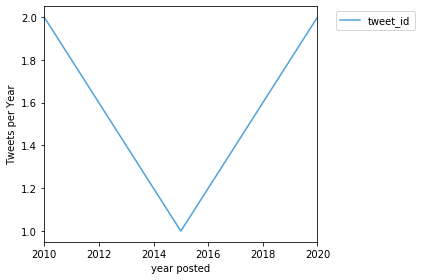

In [15]:
# number of tweets over the years

tweets.groupby('year posted').count()['tweet_id'].plot(color='#007ACC', alpha=0.7)
plt.ylabel('Tweets per Year')


plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.grid(False)

plt.savefig('Results/line_plot_tweet_per_year',dpi=300, bbox_inches='tight')




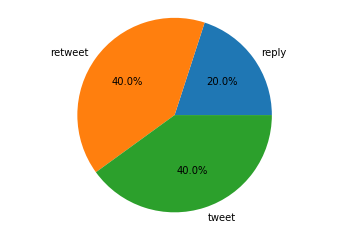

In [16]:
# pie chart of tweet types (tweet, reply, and retweet)


tweet_type= tweets.groupby('type').size()



fig1, ax1 = plt.subplots()
ax1.pie(tweet_type, labels=list(tweet_type.index), autopct='%1.1f%%', shadow=False)
ax1.axis('equal')
plt.savefig('Results/tweet_type.png', dpi=300, bbox_inches='tight')


plt.show()



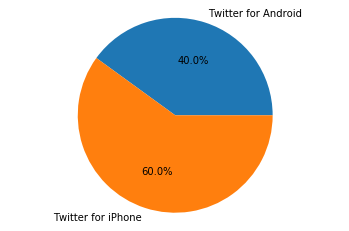

In [17]:
# pie chart of tweet sources (iphone, android, web ...etc)

tweet_source = tweets.groupby('tweet_source').size()


fig1, ax1 = plt.subplots()
ax1.pie(tweet_source, labels=list(tweet_source.index), autopct='%1.1f%%', shadow=False)


ax1.axis('equal')
plt.show()


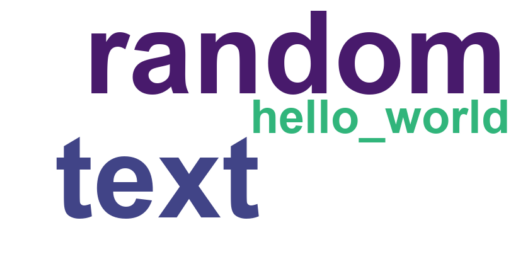

In [18]:
get_word_cloud(tweets['cleaned_tweet'],'tweet')

2010


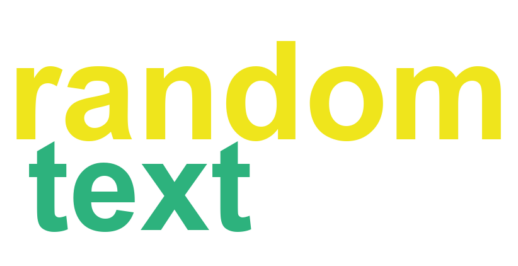

2015


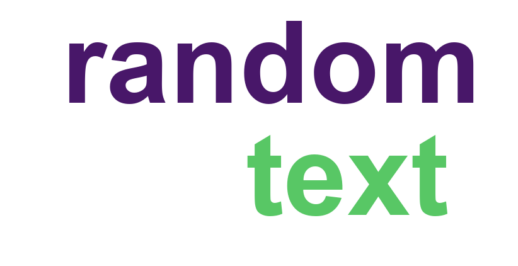

2020


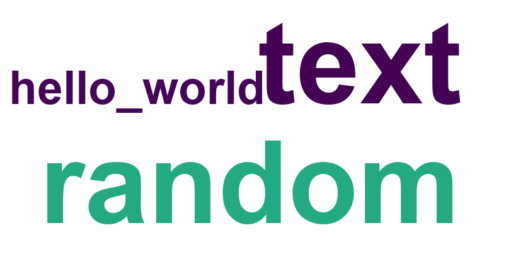

In [19]:
# plot word clouds of tweets over the years.

for y in sorted(set(tweets['year posted'])):
    print(y)
    sub_tweets=tweets[tweets['year posted']==y]
    get_word_cloud(sub_tweets['cleaned_tweet'],'tweet')


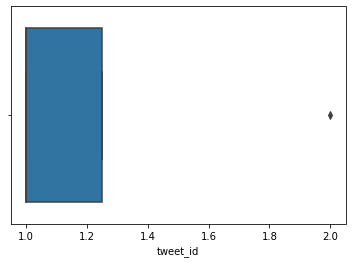

In [20]:
# plot boxplot of frequency of tweets per day

tweets_per_day=tweets.groupby('date posted').count()['tweet_id'].to_frame().sort_values(by='tweet_id',ascending=False)
ax = sns.boxplot(x=tweets_per_day["tweet_id"])



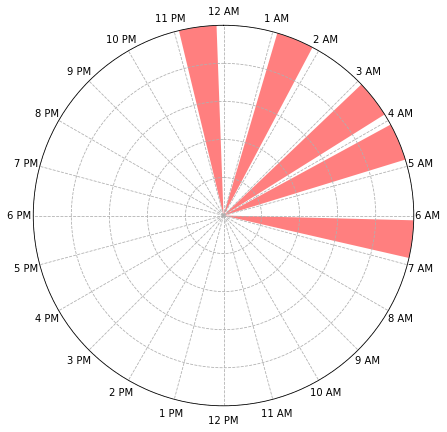

In [21]:
# plot frequency of tweets in in a day.
plot_time(tweets)

2010


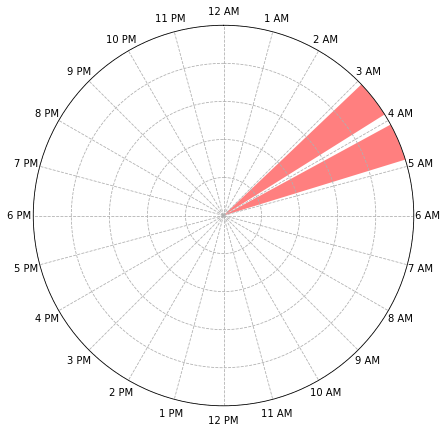

2015


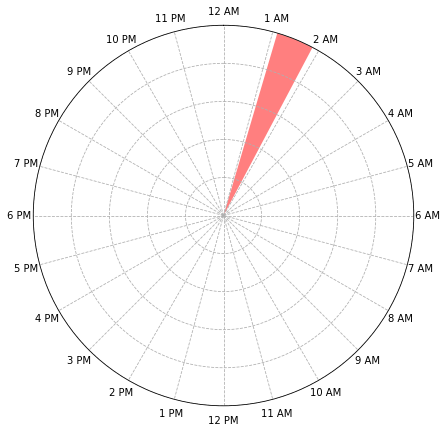

2020


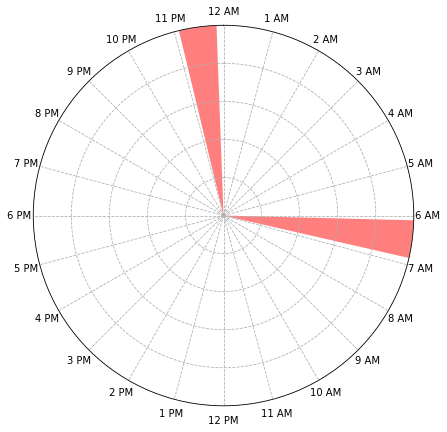

In [22]:
# plot frequency of tweets in in a day over the years.

for y in sorted(set(tweets['year posted'])):
    print(y)
    sub_tweets=tweets[tweets['year posted']==y]
    plot_time(sub_tweets)


In [23]:
likes=pd.read_csv('demo_data/csv/likes.csv')

In [24]:
#remove URLS and @ symbol
likes['cleaned_likes']=[re.sub(r"(?:\@|https?\://)\S+", "", tweet) for tweet in likes['liked_tweet']] 

In [25]:
likes=likes.dropna(subset=['cleaned_likes'])

## Word Cloud of liked tweets

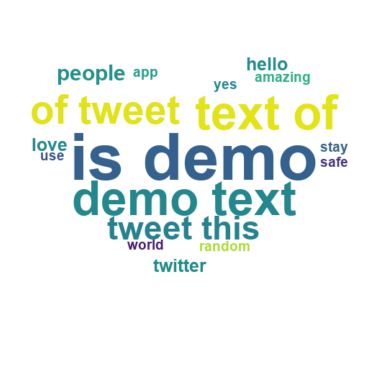

In [26]:
get_word_cloud(likes['cleaned_likes'],'like')

## Bar chart of Number of the Tweets

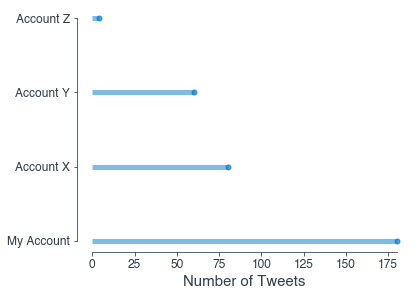

In [27]:

# set font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

# set the style of the axes and the text color
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['text.color']='#333F4B'

accounts=['My Account','Account X','Account Y','Account Z']
tweets_num=[180,80,60,4] # dummy data

my_range=list(range(1,len(accounts)+1))


fig, ax = plt.subplots(figsize=(6,4.5))

plt.hlines(y=my_range, xmin=0, xmax=tweets_num, color='#007ACC', alpha=0.5, linewidth=5)

plt.plot(tweets_num, my_range, "o", markersize=5, color='#007ACC', alpha=0.7)

# set labels
ax.set_xlabel('Number of Tweets', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('')

# set axis
ax.tick_params(axis='both', which='major', labelsize=12)
plt.yticks(my_range, accounts)


# change the style of the axis spines
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)
ax.grid(False)

plt.savefig('Results/bar_chart_tweets_num.png', dpi=300, bbox_inches='tight')

# source: https://scentellegher.github.io/visualization/2018/10/10/beautiful-bar-plots-matplotlib.html

## Networks

In [28]:
#network of hashtags

hashtags=pd.read_csv('demo_data/csv/hashtags.csv')
hashtags=hashtags.reset_index()

#find top hashtags in your tweets
hashtags_count=hashtags.groupby(['hashtag','account']).count().sort_values(by='index',ascending=False).reset_index()

#hashtags are target, you(account) is the source and the frequency of interaction with a hashtag is the weight
hashtags_count.columns=['target','source','Weight'] 

In [29]:
hashtags_count

,target,source,Weight
0,Random,You,2
1,hello_world,You,1
2,text,You,1


/Users/shahadalthobaiti/opt/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/shahadalthobaiti/opt/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


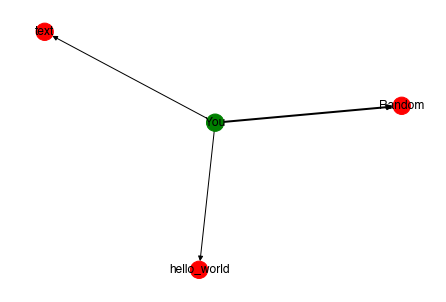

In [30]:
# Build your graph
G=nx.from_pandas_edgelist(hashtags_count, 'source', 'target',edge_attr='Weight',create_using=nx.DiGraph())
 
edges = G.edges()
weights = [G[u][v]['Weight'] for u,v in edges]
color_map = []
for node in G:
    if node in ['You']: # the name of source account id that you chose
        color_map.append('green')
    else: 
        color_map.append('red')      


nx.draw(G, edges=edges, node_color=color_map, width=weights, with_labels=True)


plt.show()


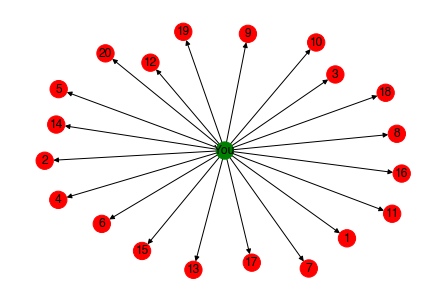

In [31]:
## Following Networks

following=pd.read_csv('demo_data/csv/following.csv')
following.columns=['target','source']
G=nx.from_pandas_edgelist(following, 'source', 'target',create_using=nx.DiGraph())
 
color_map = []
for node in G:
    if node in ['You']: # the name of source account id that you chose
        color_map.append('green')
    else: 
        color_map.append('red')      

nx.draw(G, node_color=color_map, with_labels=True)


plt.show()



## Plotting the sum of how many favorites and retweets received to your tweets

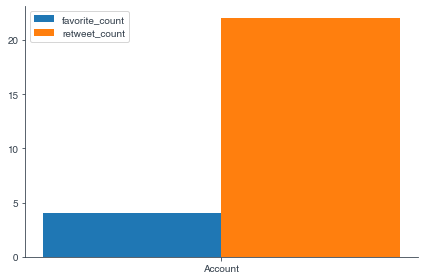

In [32]:

only_tweets_created_by_user=tweets[tweets['type']!='retweet']
# data 
labels = ['Account']
fav = sum(only_tweets_created_by_user.favorite_count)
ret = sum(only_tweets_created_by_user.retweet_count)



x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, fav, width, label='favorite_count')
rects2 = ax.bar(x + width/2, ret, width, label='retweet_count')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')


ax.grid(False,axis='x')

fig.tight_layout()
plt.savefig('Results/retweets_favs_counts.png',dpi=300, bbox_inches='tight')






## Interaction Heatmap

In [33]:
#For sake of demonstration the interaction heatmap I assumed tweets belong to diffrent users 
#Note: Please make sure you merge the tweets of multiple accounts into one dataframe and 
#adding a column to indicate the id for the accounts

tweets['account_id']=[1,2,1,2,3] 

In [34]:
# Interaction matrix
interactions=[]
all_accounts_ids=[1,2,3]
all_accounts_labels=['My account','Account X','Account Y']
for account_id in all_accounts_ids: #source: to check interaction for
    row=[]
    sub_tweets=tweets[tweets['account_id']==account_id]
    for account_id in all_accounts_ids: #target to check interaction with
        row.append(len(sub_tweets[sub_tweets['retweeted_from_id']==account_id])+
                   len(sub_tweets[sub_tweets['reply_to_id']==account_id]))
    interactions.append(row)

In [35]:
interactions

[[2, 0, 0], [1, 0, 0], [0, 0, 0]]

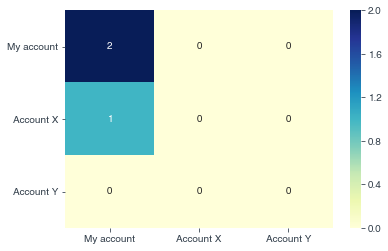

In [36]:
# plot interactions
sns.heatmap(interactions,xticklabels=all_accounts_labels, yticklabels=all_accounts_labels, cmap="YlGnBu",annot=True, fmt="d")
plt.yticks(rotation=0) 
plt.savefig('Results/interaction_heatmap.png',dpi=300, bbox_inches='tight')


